This version of the snake game allows you to implement and run your evolutionary algorithm

In [1167]:
import random
import time
import turtle
import random
from datetime import datetime

from deap import base
from deap import creator
from deap import tools

In [1168]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

In [ ]:
from enum import  Enum

class Directions(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle,  to run it again properly you might need to go to restart your kernel after the visualization has finished.

If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.

In [1169]:
HEADLESS = True

In [1170]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        #self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color(random.choice(["green",'black','red','blue']))
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [1171]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0] ]# Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.ahead = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:                                            # When snake eats the food
            return True
        else:    
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Example sensing functions
    def getAheadLocation(self):
        self.ahead = [ self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)] 
        
    def sense_wall_ahead(self):
        self.getAheadLocation()
        return( self.ahead[0] == 0 or self.ahead[0] == (YSIZE-1) or self.ahead[1] == 0 or self.ahead[1] == (XSIZE-1) )
        
    def sense_food_ahead(self):
        self.getAheadLocation()
        return self.food == self.ahead

    def sense_tail_ahead(self):
        self.getAheadLocation()
        return self.ahead in self.snake

    def sense_get_food_angle(self):
        unit_vector_1 = self.snake[0] / np.linalg.norm(self.snake[0])
        unit_vector_2 = self.food / np.linalg.norm(self.food)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        return np.cos(angle)

    def sense_food_distance(self):
        return (np.linalg.norm(np.asarray(self.snake[0]) - np.asarray(self.food)) - 22.63)/22.63


In [1172]:
import numpy as np
import math

class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node from input to hidden layer 1 only
        self.numHidden1 = numHidden1 # Feel free to adapt the code to add more biases if you wish
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)             # Add bias input

        h1 = np.dot(self.w_i_h1, inputsBias)         # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)                 # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        #output = [self.sigmoid(x) for x in output]   # Activate output layer
        return self.softmax(output)

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

In [1173]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 5
numHiddenNodes1 = 2
numHiddenNodes2 = 2
numOutputNodes = 4

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

C:\Users\Sam\AppData\Local\Temp/ipykernel_1928/3475129922.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [1174]:
myNet = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

In [1175]:
snake_game = snake(XSIZE,YSIZE)

In [1176]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

In [1177]:
def evaluate(indiv, myNet):
    fitness = 0
    myNet.setWeightsLinear(indiv)
    fitness = run_game(display,myNet,snake_game)
    return fitness,

In [1178]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selRoulette)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [1179]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [1180]:
def run_game(display,brain,snake_game, headless=True):

    score = 0
    timestep = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False
    snake_direction = "right"

    flag = True
    while not game_over:

        # ****YOUR AI BELOW HERE******************

        # Here is a very silly random snake controller. It moves with a correlated random walk, and the only sensible decision it makes is not to turn directly back on itself (possible in this game)
        # *** Replace this with your evolved controller here to decide on the direction the snake should take*

        def move_ai(brain):
            output = brain.feed_forward([snake_game.sense_tail_ahead(),snake_game.sense_food_ahead(),snake_game.sense_wall_ahead(),snake_game.sense_get_food_angle(),snake_game.sense_food_distance()])
            decision = np.argmax(output,axis=0)

            if decision  == 0:
                new_snake_direction = "left"
            elif decision == 1:
                new_snake_direction = "right"
            elif decision == 2:
                new_snake_direction = "up"
            elif decision ==3:
                new_snake_direction = "down"
            print(new_snake_direction)
            return new_snake_direction

        snake_game.snake_direction = move_ai(brain)
        timestep+=1
        # Here is an example sensing function
        if snake_game.sense_tail_ahead():
            print("Tail ahead!!!!")
            time.sleep(0.5)
        
        # ****YOUR AI ABOVE HERE******************
            
        snake_game.update_snake_position()

        # Check if food is eaten
        if snake_game.food_eaten():
            snake_game.place_food()
            print("Food Eaten!")
            score += 1
            if not headless: display.add_snake_segment()

        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            score -=1
            game_over = True
            print("Snake turned into itself!")

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            score-=1
            game_over = True
            print("Snake hit a wall!")

        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2) # Change this to modify the speed the game runs at when displayed.

    fitness = timestep*2**score
    print("\nFINAL score - " + str(score))
    print("\nFINAL fitness - " + str(fitness))
    print()
    if not headless: turtle.done()

    return fitness


In [1181]:
logbook = tools.Logbook()

pop = toolbox.population(n=5)

fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5

right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5



In [1182]:
NGEN, CXPROB = 13, 0.0

for g in range(NGEN):
    print("-- Generation %i --" % g)

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --
right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5

right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5

-- Generation 1 --
right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5

right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5

right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5

right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5

left
Tail ahead!!!!
Snake turned into itself!

FINAL score - -1

FINAL fitness - 0.5

-- Generation 2 --
right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINA

In [1183]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

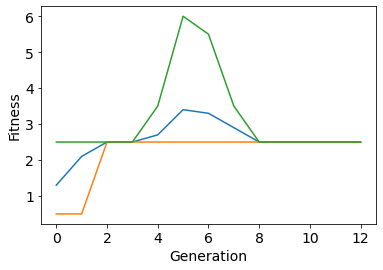

In [1184]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

In [1185]:
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

Below is what you would use for your evaluation. You would also use it to display your final (pickled and loaded) solution, with headless = False.

If you have run without headless (i.e. with the display) you will need to reset your kernel to run again. This appears to be an IPython issue with Turtle, but if you have a way to deal with that, do please let me know. You will probable only want to run it one-at-a-time anyway.

In [1186]:
bestInd = tools.selBest(pop, 1)[0]

In [1187]:
myNet.setWeightsLinear(bestInd)

In [1188]:
run_game(display,myNet,snake_game, headless=HEADLESS)

right
right
right
right
right
Snake hit a wall!

FINAL score - -1

FINAL fitness - 2.5



2.5